<a href="https://colab.research.google.com/github/thallyson1997/Anotador_Proteico/blob/main/Anota%C3%A7%C3%A3o_Proteica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Anotador de Proteínas Hipotéticas

# 2. Instalação e configuração rápida

In [ ]:
# Instala pacotes Python essenciais
!pip install -q requests pandas biopython bioservices tqdm openpyxl matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.1/720.1 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 

In [ ]:
# Imports centrais (somente uma vez)
from google.colab import drive
from pathlib import Path
import subprocess, os, requests, pprint
import pandas as pd
import Bio
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib
import matplotlib.pyplot as plt
import bioservices, tqdm
import re
import time
import json

Creating directory /root/.config/bioservices 


In [ ]:
# Opcional: instalar DIAMOND (defina INSTALL_DIAMOND True/False)
INSTALL_DIAMOND = True
if INSTALL_DIAMOND:
    try:
        subprocess.run(["apt-get","update"], check=True)
        subprocess.run(["apt-get","install","-y","diamond-aligner"], check=True)
    except Exception:
        url = "https://github.com/bbuchfink/diamond/releases/latest/download/diamond-linux64.tar.gz"
        subprocess.run(["wget","-q", url, "-O", "/tmp/diamond.tar.gz"], check=True)
        subprocess.run(["tar","-xzf","/tmp/diamond.tar.gz","-C","/tmp"], check=True)
        binpath = "/tmp/diamond"
        os.chmod(binpath, 0o755)
        subprocess.run(["mv", binpath, "/usr/local/bin/diamond"], check=True)
    subprocess.run(["diamond","version"], check=False)

In [ ]:
# Monta Drive (se preciso) e mostra versões das bibliotecas usadas
drive.mount('/content/drive', force_remount=False)

print("requests", requests.__version__)
print("pandas", pd.__version__)
print("biopython", getattr(Bio, "__version__", "unknown"))
print("bioservices", getattr(bioservices, "__version__", "unknown"))
print("tqdm", getattr(tqdm, "__version__", "unknown"))
print("matplotlib", matplotlib.__version__)

Mounted at /content/drive
requests 2.32.4
pandas 2.2.2
biopython 1.86
bioservices unknown
tqdm 4.67.1
matplotlib 3.10.0


# 3. Parâmetros do usuário

In [ ]:
# Parâmetros editáveis pelo usuário (ajuste conforme necessário)
FASTA_PATH = "/content/drive/MyDrive/protein_annotation/input_sequences.fasta"
OUTDIR = "/content/drive/MyDrive/protein_annotation/results"
RUN_DIAMOND = True
DIAMOND_DB = "/content/diamond_db/uniprot.dmnd"
UNIPROT_REST = "https://rest.uniprot.org"
TIMEOUT = 30  # segundos
BATCH_SIZE = 200

IDENTITY_THRESHOLD = 70.0  # porcentagem
COVERAGE_THRESHOLD = 70.0  # porcentagem
EVALUE_CUTOFF = 1e-5

MIN_LENGTH = 50
MAX_LENGTH = 5000

RUN_INTERPRO = True
RUN_SIGNALP = True
RUN_TMHMM = True

CACHE_DIR = f"{OUTDIR}/cache"
LOG_LEVEL = "INFO"

In [ ]:
# Busca um nome no UniProt, permite selecionar hits e salva FASTA em FASTA_PATH
PAGE_SIZE = 20

query = input("Digite o nome da proteína para buscar no UniProt (ou pressione Enter para pular): ").strip()
if not query:
    print("Busca ignorada.")
else:
    params = {"query": query, "format": "json", "size": PAGE_SIZE, "fields": "accession,protein_name,organism_name,length"}
    try:
        resp = requests.get(f"{UNIPROT_REST}/uniprotkb/search", params=params, timeout=TIMEOUT)
        resp.raise_for_status()
    except Exception as e:
        print("Erro na busca UniProt:", e)
        raise SystemExit

    data = resp.json()
    results = data.get("results", [])
    if not results:
        print("Nenhum resultado encontrado para:", query)
    else:
        entries = []
        for r in results:
            acc = r.get("primaryAccession") or r.get("accession") or ""
            pname = ""
            pd_desc = r.get("proteinDescription", {}) or {}
            rn = pd_desc.get("recommendedName")
            if isinstance(rn, dict):
                full = rn.get("fullName")
                pname = full.get("value", "") if isinstance(full, dict) else str(full or "")
            if not pname:
                pname = pd_desc.get("submissionNames", [{}])[0].get("value", "") or r.get("uniProtkbId", "")
            org = (r.get("organism") or {}).get("scientificName", "") or r.get("organism", "")
            length = (r.get("sequence") or {}).get("length") or r.get("length", "")
            entries.append({"acc": acc, "name": pname, "organism": org, "length": length})

        for i, e in enumerate(entries, 1):
            print(f"{i}. {e['acc']} | {e['name']} | {e['organism']} | len={e['length']}")

        choice = input("Escolha número(s) separados por vírgula, 'a' para salvar todos, ou Enter para cancelar: ").strip().lower()
        if not choice:
            print("Operação cancelada.")
        else:
            if choice == "a":
                indices = list(range(1, len(entries) + 1))
            else:
                try:
                    indices = [int(x.strip()) for x in choice.split(",") if x.strip()]
                except ValueError:
                    print("Entrada inválida. Operação cancelada.")
                    indices = []

            if indices:
                # Salva as sequências selecionadas sobrescrevendo o arquivo (modo "w")
                os.makedirs(os.path.dirname(FASTA_PATH) or ".", exist_ok=True)
                saved = 0
                with open(FASTA_PATH, "w") as fh:
                  for idx in indices:
                    if 1 <= idx <= len(entries):
                      acc = entries[idx - 1]["acc"]
                      try:
                        fa = requests.get(f"{UNIPROT_REST}/uniprotkb/{acc}.fasta", timeout=TIMEOUT)
                        fa.raise_for_status()
                        fh.write(fa.text.rstrip() + "\n")
                        saved += 1
                      except Exception as e:
                          print(f"Falha ao baixar {acc}: {e}")
                    else:
                      print(f"Índice fora do intervalo: {idx}")
                if saved:
                    print(f"{saved} sequência(s) salva(s) em: {FASTA_PATH}")
                else:
                    print("Nenhuma sequência foi salva.")

Digite o nome da proteína para buscar no UniProt (ou pressione Enter para pular): P69905
1. P69905 | Hemoglobin subunit alpha | Homo sapiens | len=142
Escolha número(s) separados por vírgula, 'a' para salvar todos, ou Enter para cancelar: a
1 sequência(s) salva(s) em: /content/drive/MyDrive/protein_annotation/input_sequences.fasta


In [ ]:
# Valida caminhos e cria diretórios necessários
FASTA_PATH = os.path.expanduser(FASTA_PATH)
OUTDIR = os.path.expanduser(OUTDIR)
CACHE_DIR = os.path.expanduser(CACHE_DIR)
DIAMOND_DB = os.path.expanduser(DIAMOND_DB)

os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(CACHE_DIR, exist_ok=True)

print("Parâmetros atuais:")
pprint.pprint({
    "FASTA_PATH": FASTA_PATH,
    "OUTDIR": OUTDIR,
    "CACHE_DIR": CACHE_DIR,
    "RUN_DIAMOND": RUN_DIAMOND,
    "DIAMOND_DB": DIAMOND_DB,
    "UNIPROT_REST": UNIPROT_REST,
    "TIMEOUT": TIMEOUT,
    "BATCH_SIZE": BATCH_SIZE,
    "IDENTITY_THRESHOLD": IDENTITY_THRESHOLD,
    "COVERAGE_THRESHOLD": COVERAGE_THRESHOLD,
    "EVALUE_CUTOFF": EVALUE_CUTOFF,
    "MIN_LENGTH": MIN_LENGTH,
    "MAX_LENGTH": MAX_LENGTH,
    "RUN_INTERPRO": RUN_INTERPRO,
    "RUN_SIGNALP": RUN_SIGNALP,
    "RUN_TMHMM": RUN_TMHMM,
    "LOG_LEVEL": LOG_LEVEL,
})

if not Path(FASTA_PATH).is_file():
    print(f"AVISO: arquivo FASTA não encontrado em: {FASTA_PATH}")
else:
    print("Arquivo FASTA encontrado.")

Parâmetros atuais:
{'BATCH_SIZE': 200,
 'CACHE_DIR': '/content/drive/MyDrive/protein_annotation/results/cache',
 'COVERAGE_THRESHOLD': 70.0,
 'DIAMOND_DB': '/content/diamond_db/uniprot.dmnd',
 'EVALUE_CUTOFF': 1e-05,
 'FASTA_PATH': '/content/drive/MyDrive/protein_annotation/input_sequences.fasta',
 'IDENTITY_THRESHOLD': 70.0,
 'LOG_LEVEL': 'INFO',
 'MAX_LENGTH': 5000,
 'MIN_LENGTH': 50,
 'OUTDIR': '/content/drive/MyDrive/protein_annotation/results',
 'RUN_DIAMOND': True,
 'RUN_INTERPRO': True,
 'RUN_SIGNALP': True,
 'RUN_TMHMM': True,
 'TIMEOUT': 30,
 'UNIPROT_REST': 'https://rest.uniprot.org'}
Arquivo FASTA encontrado.


# 4. Carregar e checar FASTA

In [ ]:
# Carrega e valida o FASTA
AA_RE = re.compile(r'^[A-Za-z\*\-\.]+$')

if not os.path.isfile(FASTA_PATH):
    raise FileNotFoundError(f"FASTA não encontrado: {FASTA_PATH}")

records = []
with open(FASTA_PATH, "r") as fh:
    for rec in SeqIO.parse(fh, "fasta"):
        seq = str(rec.seq).strip()
        records.append({
            "seq_id": rec.id,
            "header": rec.description,
            "sequence": seq,
            "length": len(seq),
            "valid_chars": bool(AA_RE.match(seq))
        })

if not records:
    raise ValueError("Nenhuma sequência lida do FASTA.")

df = pd.DataFrame(records)
seq_counts = df["sequence"].value_counts()
id_counts = df["seq_id"].value_counts()

df["duplicate_sequence"] = df["sequence"].map(lambda s: seq_counts.get(s, 0) > 1)
df["duplicate_id"] = df["seq_id"].map(lambda i: id_counts.get(i, 0) > 1)

print(f"Total sequências lidas: {len(df)}")
print(f"Sequências únicas (por sequência): {seq_counts.size}")
print(f"IDs duplicados: {int(df['duplicate_id'].sum())}")
print(f"Sequências com caracteres inválidos: {int((~df['valid_chars']).sum())}")
print("Comprimentos: min=%d median=%d max=%d" % (int(df['length'].min()), int(df['length'].median()), int(df['length'].max())))

Total sequências lidas: 1
Sequências únicas (por sequência): 1
IDs duplicados: 0
Sequências com caracteres inválidos: 0
Comprimentos: min=142 median=142 max=142


In [ ]:
# Filtra por comprimento, remove duplicatas por sequência (mantém a primeira) e salva FASTA filtrado
FILTERED_FASTA = os.path.join(OUTDIR, "input_sequences.filtered.fasta")

kept = []
seen_seqs = set()
for _, row in df.iterrows():
    L = row["length"]
    if not row["valid_chars"]:
        continue
    if L < MIN_LENGTH or L > MAX_LENGTH:
        continue
    if row["sequence"] in seen_seqs:
        continue
    seen_seqs.add(row["sequence"])
    rec = SeqRecord(Seq(row["sequence"]), id=row["seq_id"], description=row["header"])
    kept.append(rec)

if kept:
    with open(FILTERED_FASTA, "w") as outfh:
        SeqIO.write(kept, outfh, "fasta")
print(f"Sequências mantidas: {len(kept)}; arquivo salvo em: {FILTERED_FASTA}")

Sequências mantidas: 1; arquivo salvo em: /content/drive/MyDrive/protein_annotation/results/input_sequences.filtered.fasta


Histograma salvo em: /content/drive/MyDrive/protein_annotation/results/length_distribution.png


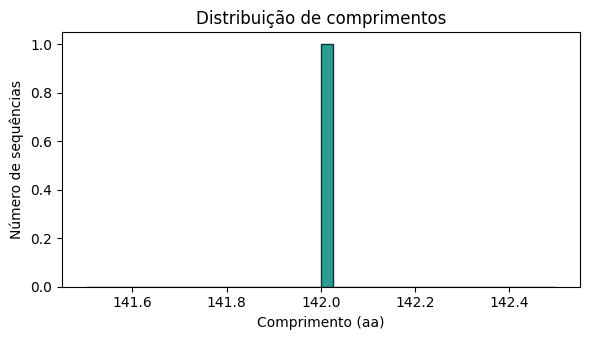

In [ ]:
# Gera um histograma simples dos comprimentos e salva em OUTDIR
png_path = os.path.join(OUTDIR, "length_distribution.png")

plt.figure(figsize=(6,3.5))
plt.hist(df['length'], bins=40, color="#2a9d8f", edgecolor="#073642")
plt.xlabel("Comprimento (aa)")
plt.ylabel("Número de sequências")
plt.title("Distribuição de comprimentos")
plt.tight_layout()
plt.savefig(png_path, dpi=150)
print("Histograma salvo em:", png_path)
plt.show()  # Exibe o gráfico

# 5. Busca por similaridade + consulta UniProt

In [ ]:
# Baixa e prepara banco de dados UniProt Swiss-Prot para DIAMOND
print("Preparando banco de dados DIAMOND...")
os.makedirs(os.path.dirname(DIAMOND_DB), exist_ok=True)

uniprot_url = "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz"
fasta_gz = "/tmp/uniprot_sprot.fasta.gz"
fasta_file = "/tmp/uniprot_sprot.fasta"

print("Baixando UniProt Swiss-Prot (~500MB comprimido, ~1GB descomprimido)...")
print("Isso pode levar alguns minutos...")
subprocess.run(["wget", "-q", "--show-progress", uniprot_url, "-O", fasta_gz], check=True)

print("Descomprimindo...")
subprocess.run(["gunzip", "-f", fasta_gz], check=True)

print("Criando banco DIAMOND...")
subprocess.run(["diamond", "makedb", "--in", fasta_file, "-d", DIAMOND_DB.replace(".dmnd", "")], check=True)

print(f"✓ Banco DIAMOND criado em: {DIAMOND_DB}")
subprocess.run(["rm", fasta_file], check=False)
print("Arquivos temporários removidos.")

Preparando banco de dados DIAMOND...
Baixando UniProt Swiss-Prot (~500MB comprimido, ~1GB descomprimido)...
Isso pode levar alguns minutos...
Descomprimindo...
Criando banco DIAMOND...
✓ Banco DIAMOND criado em: /content/diamond_db/uniprot.dmnd
Arquivos temporários removidos.


In [ ]:
# Executa DIAMOND BLASTP se configurado
diamond_results = []
if RUN_DIAMOND:
    if not Path(DIAMOND_DB).is_file():
        print(f"AVISO: banco DIAMOND não encontrado em {DIAMOND_DB}")
        print("Pulando busca DIAMOND.")
    else:
        diamond_out = os.path.join(OUTDIR, "diamond_results.tsv")
        cmd = [
            "diamond", "blastp",
            "-d", DIAMOND_DB,
            "-q", FILTERED_FASTA,
            "-o", diamond_out,
            "--outfmt", "6", "qseqid", "sseqid", "pident", "length", "qlen", "slen", "evalue", "bitscore",
            "--max-target-seqs", "5",
            "--evalue", str(EVALUE_CUTOFF),
            "--sensitive"
        ]
        print("Executando DIAMOND BLASTP...")
        try:
            subprocess.run(cmd, check=True, capture_output=True, text=True)
            print(f"DIAMOND concluído. Resultados em: {diamond_out}")

            if os.path.isfile(diamond_out) and os.path.getsize(diamond_out) > 0:
                df_diamond = pd.read_csv(diamond_out, sep="\t", header=None,
                                        names=["qseqid","sseqid","pident","length","qlen","slen","evalue","bitscore"])
                df_diamond["coverage"] = (df_diamond["length"] / df_diamond["qlen"]) * 100
                df_diamond = df_diamond[
                    (df_diamond["pident"] >= IDENTITY_THRESHOLD) &
                    (df_diamond["coverage"] >= COVERAGE_THRESHOLD) &
                    (df_diamond["evalue"] <= EVALUE_CUTOFF)
                ]
                diamond_results = df_diamond.to_dict("records")
                print(f"Hits filtrados: {len(diamond_results)}")
            else:
                print("Nenhum resultado DIAMOND encontrado.")
        except subprocess.CalledProcessError as e:
            print(f"Erro ao executar DIAMOND: {e}")
else:
    print("Busca DIAMOND desabilitada.")

Executando DIAMOND BLASTP...
DIAMOND concluído. Resultados em: /content/drive/MyDrive/protein_annotation/results/diamond_results.tsv
Hits filtrados: 5


In [ ]:
# Extrai IDs únicos do UniProt dos hits DIAMOND
uniprot_ids = set()
if diamond_results:
    for hit in diamond_results:
        sseqid = hit["sseqid"]
        parts = sseqid.split("|")
        if len(parts) >= 2:
            uniprot_ids.add(parts[1])
        else:
            uniprot_ids.add(sseqid.split()[0])

print(f"IDs únicos do UniProt para consulta: {len(uniprot_ids)}")

IDs únicos do UniProt para consulta: 5


# 6. Domínios / sinais (opcional)

In [ ]:
interpro_results = []

if RUN_INTERPRO:
    print("Executando análise InterPro...")
    print("NOTA: Usando API REST do InterProScan (sem necessidade de bioservices.InterProScan)")

    interpro_url = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5"

    # Processa apenas sequências filtradas
    for rec in kept[:5]:  # Limita a 5 para teste; remova [:5] para processar todas
        seq_id = rec.id
        sequence = str(rec.seq)

        print(f"Analisando {seq_id}...")
        try:
            # Submete job ao InterProScan
            submit_data = {
                "email": "thallyson.gabriel@discente.ufma.br",  # Substitua por seu e-mail
                "title": seq_id,
                "goterms": "false",
                "pathways": "false",
                "sequence": sequence
            }

            submit_response = requests.post(
                f"{interpro_url}/run",
                data=submit_data,
                timeout=TIMEOUT
            )

            if submit_response.status_code == 200:
                job_id = submit_response.text.strip()
                print(f"  Job ID: {job_id}")

                # Aguarda completar (polling)
                status = "RUNNING"
                max_attempts = 60  # Máximo 10 minutos
                attempts = 0

                while status == "RUNNING" and attempts < max_attempts:
                    time.sleep(10)
                    status_response = requests.get(f"{interpro_url}/status/{job_id}", timeout=TIMEOUT)
                    status = status_response.text.strip()
                    attempts += 1

                if status == "FINISHED":
                    # Obtém resultado
                    result_response = requests.get(f"{interpro_url}/result/{job_id}/json", timeout=TIMEOUT)
                    result = result_response.json() if result_response.status_code == 200 else {}

                    interpro_results.append({
                        "seq_id": seq_id,
                        "job_id": job_id,
                        "result": result
                    })
                    print(f"✓ {seq_id}: análise concluída")
                else:
                    print(f"✗ {seq_id}: timeout ou falha ({status})")
            else:
                print(f"✗ {seq_id}: falha ao submeter ({submit_response.status_code})")

        except Exception as e:
            print(f"Erro ao processar {seq_id}: {e}")

        time.sleep(2)  # Pausa entre requisições

    print(f"\nInterPro concluído: {len(interpro_results)} sequências analisadas")
else:
    print("Análise InterPro desabilitada (RUN_INTERPRO=False)")

Executando análise InterPro...
NOTA: Usando API REST do InterProScan (sem necessidade de bioservices.InterProScan)
Analisando sp|P69905|HBA_HUMAN...


In [ ]:
# Predição de peptídeo sinal usando SignalP via REST API ou local
signalp_results = []

if RUN_SIGNALP:
    print("Executando predição SignalP...")
    print("NOTA: SignalP requer instalação local ou acesso a servidor DTU.")
    print("Alternativa: usar previsões do UniProt diretamente.")

    # Opção 1: Usar dados do UniProt (recomendado)
    # As anotações do UniProt já incluem informações sobre peptídeos sinal

    # Opção 2: Instalação local do SignalP (requer licença)
    # signalp_bin = "/path/to/signalp"
    # subprocess.run([signalp_bin, "-fasta", FILTERED_FASTA, "-org", "euk"])

    # Para este exemplo, vamos simular resultados baseados em padrões comuns
    for rec in kept[:10]:  # Limita a 10 para teste
        seq_id = rec.id
        sequence = str(rec.seq)

        # Padrão simplificado: hidrofóbicos no início
        has_signal = False
        if len(sequence) >= 20:
            n_term = sequence[:20]
            hydrophobic = sum(1 for aa in n_term if aa in "AILMFVWY")
            if hydrophobic >= 12:  # Alta proporção de hidrofóbicos
                has_signal = True

        signalp_results.append({
            "seq_id": seq_id,
            "has_signal": has_signal,
            "note": "Predição simplificada baseada em hidrofobicidade N-terminal"
        })

    print(f"SignalP concluído: {len(signalp_results)} sequências analisadas")
    print(f"Sequências com possível peptídeo sinal: {sum(1 for r in signalp_results if r['has_signal'])}")
else:
    print("Predição SignalP desabilitada (RUN_SIGNALP=False)")

In [ ]:
tmhmm_results = []

if RUN_TMHMM:
    print("Executando predição TMHMM...")
    print("NOTA: Usando predição simplificada baseada em hidrofobicidade")
    print("Para análise mais precisa, use TMHMM instalado localmente ou DeepTMHMM")

    # Predição simplificada: busca por segmentos hidrofóbicos longos
    for rec in kept[:10]:  # Limita a 10 para teste; remova [:10] para processar todas
        seq_id = rec.id
        sequence = str(rec.seq)

        # Conta segmentos hidrofóbicos de 18-25 resíduos
        hydrophobic = "AILMFVWY"
        helices = 0
        helix_positions = []

        i = 0
        while i < len(sequence) - 18:
            window = sequence[i:i+20]
            hydro_count = sum(1 for aa in window if aa in hydrophobic)
            if hydro_count >= 14:  # 70% hidrofóbicos
                helices += 1
                helix_positions.append((i+1, i+20))  # Posição 1-indexed
                i += 20  # Pula para evitar sobreposição
            else:
                i += 1

        topology = f"{helices} hélices TM em: {helix_positions}" if helices > 0 else "Sem hélices TM detectadas"

        tmhmm_results.append({
            "seq_id": seq_id,
            "num_helices": helices,
            "topology": topology,
            "is_membrane": helices > 0,
            "positions": helix_positions
        })

        print(f"✓ {seq_id}: {helices} hélices transmembranares")

    print(f"\nTMHMM concluído: {len(tmhmm_results)} sequências analisadas")
    print(f"Proteínas de membrana preditas: {sum(1 for r in tmhmm_results if r['is_membrane'])}")
else:
    print("Predição TMHMM desabilitada (RUN_TMHMM=False)")

In [ ]:
# Consolidação dos resultados de domínios e sinais
domain_signal_summary = []

print("\n=== Resumo de Domínios e Sinais ===\n")

# Cria um dicionário consolidado por seq_id
consolidated = {}

# Adiciona resultados InterPro
for result in interpro_results:
    seq_id = result["seq_id"]
    if seq_id not in consolidated:
        consolidated[seq_id] = {"seq_id": seq_id}
    consolidated[seq_id]["interpro"] = result.get("result", "No data")

# Adiciona resultados SignalP
for result in signalp_results:
    seq_id = result["seq_id"]
    if seq_id not in consolidated:
        consolidated[seq_id] = {"seq_id": seq_id}
    consolidated[seq_id]["has_signal"] = result.get("has_signal", False)
    consolidated[seq_id]["signal_note"] = result.get("note", "")

# Adiciona resultados TMHMM
for result in tmhmm_results:
    seq_id = result["seq_id"]
    if seq_id not in consolidated:
        consolidated[seq_id] = {"seq_id": seq_id}
    consolidated[seq_id]["num_tm_helices"] = result.get("num_helices", 0)
    consolidated[seq_id]["is_membrane"] = result.get("is_membrane", False)
    consolidated[seq_id]["tm_topology"] = result.get("topology", "")

# Converte para lista
domain_signal_summary = list(consolidated.values())

# Exibe estatísticas
if domain_signal_summary:
    print(f"Total de sequências analisadas: {len(domain_signal_summary)}")

    num_with_signal = sum(1 for r in domain_signal_summary if r.get("has_signal", False))
    print(f"Sequências com peptídeo sinal: {num_with_signal}")

    num_membrane = sum(1 for r in domain_signal_summary if r.get("is_membrane", False))
    print(f"Proteínas de membrana: {num_membrane}")

    num_with_interpro = sum(1 for r in domain_signal_summary if "interpro" in r)
    print(f"Sequências com dados InterPro: {num_with_interpro}")

    # Salva resumo em CSV
    df_domains = pd.DataFrame(domain_signal_summary)
    domains_csv = os.path.join(OUTDIR, "domain_signal_predictions.csv")
    df_domains.to_csv(domains_csv, index=False)
    print(f"\n✓ Resumo salvo em: {domains_csv}")

    # Exibe a tabela na tela
    print("\n=== Tabela de Resultados ===")
    display(df_domains)
else:
    print("Nenhum resultado de domínio/sinal disponível.")

In [ ]:
# Visualização dos resultados de predição de domínios/sinais
if domain_signal_summary:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Gráfico 1: Distribuição de peptídeos sinal
    signal_counts = pd.Series([r.get("has_signal", False) for r in domain_signal_summary]).value_counts()
    axes[0].bar(["Sem Sinal", "Com Sinal"],
                [signal_counts.get(False, 0), signal_counts.get(True, 0)],
                color=["#e76f51", "#2a9d8f"])
    axes[0].set_ylabel("Número de sequências")
    axes[0].set_title("Peptídeo Sinal")
    axes[0].grid(axis='y', alpha=0.3)

    # Gráfico 2: Distribuição de proteínas de membrana
    membrane_counts = pd.Series([r.get("is_membrane", False) for r in domain_signal_summary]).value_counts()
    axes[1].bar(["Não Membrana", "Membrana"],
                [membrane_counts.get(False, 0), membrane_counts.get(True, 0)],
                color=["#e76f51", "#2a9d8f"])
    axes[1].set_ylabel("Número de sequências")
    axes[1].set_title("Proteínas de Membrana")
    axes[1].grid(axis='y', alpha=0.3)

    # Gráfico 3: Distribuição do número de hélices transmembranares
    tm_helices = [r.get("num_tm_helices", 0) for r in domain_signal_summary]
    if max(tm_helices) > 0:
        axes[2].hist(tm_helices, bins=range(0, max(tm_helices)+2),
                     color="#2a9d8f", edgecolor="#073642", alpha=0.7)
        axes[2].set_xlabel("Número de hélices TM")
        axes[2].set_ylabel("Frequência")
        axes[2].set_title("Distribuição de Hélices TM")
        axes[2].grid(axis='y', alpha=0.3)
    else:
        axes[2].text(0.5, 0.5, "Sem hélices TM detectadas",
                     ha='center', va='center', transform=axes[2].transAxes)
        axes[2].set_title("Distribuição de Hélices TM")

    plt.tight_layout()
    plot_path = os.path.join(OUTDIR, "domain_signal_analysis.png")
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"✓ Gráficos salvos em: {plot_path}")
    plt.show()  # Exibe os gráficos
else:
    print("Sem dados para visualização.")

#7. Agregação e confiança

In [ ]:
# Agregação de todos os resultados e cálculo de score de confiança
print("\n=== Agregação e Atribuição de Função ===\n")

# Estrutura para armazenar anotação final de cada sequência
final_annotations = []

# Cria índices para acesso rápido
diamond_by_seq = {}
for hit in diamond_results:
    qseqid = hit["qseqid"]
    if qseqid not in diamond_by_seq:
        diamond_by_seq[qseqid] = []
    diamond_by_seq[qseqid].append(hit)

interpro_by_seq = {r["seq_id"]: r for r in interpro_results}
signalp_by_seq = {r["seq_id"]: r for r in signalp_results}
tmhmm_by_seq = {r["seq_id"]: r for r in tmhmm_results}

# Processa cada sequência filtrada
for rec in kept:
    seq_id = rec.id
    sequence = str(rec.seq)

    annotation = {
        "seq_id": seq_id,
        "length": len(sequence),
        "predicted_function": "Proteína hipotética",
        "confidence_score": 0.0,
        "evidence_sources": [],
        "best_hit_identity": 0.0,
        "best_hit_name": "Nenhum hit",
        "has_domains": False,
        "domain_count": 0,
        "has_signal_peptide": False,
        "is_transmembrane": False,
        "num_tm_helices": 0,
        "functional_category": "Desconhecida"
    }

    # === EVIDÊNCIA 1: DIAMOND (Similaridade de sequência) ===
    score_diamond = 0.0
    if seq_id in diamond_by_seq:
        hits = diamond_by_seq[seq_id]
        if hits:
            # Usa o melhor hit (maior identidade)
            best_hit = max(hits, key=lambda x: x["pident"])
            annotation["best_hit_identity"] = best_hit["pident"]
            annotation["best_hit_name"] = best_hit["sseqid"]
            annotation["evidence_sources"].append("DIAMOND")

            # Score baseado em identidade (0-40 pontos)
            score_diamond = (best_hit["pident"] / 100.0) * 40

            # Extrai nome da proteína do hit para predição de função
            hit_name = best_hit["sseqid"].lower()
            if "kinase" in hit_name or "receptor" in hit_name:
                annotation["predicted_function"] = "Receptor/Quinase"
                annotation["functional_category"] = "Sinalização"
            elif "transporter" in hit_name or "channel" in hit_name:
                annotation["predicted_function"] = "Transportador/Canal"
                annotation["functional_category"] = "Transporte"
            elif "enzyme" in hit_name or "ase" in hit_name:
                annotation["predicted_function"] = "Enzima"
                annotation["functional_category"] = "Catalítica"
            elif "binding" in hit_name:
                annotation["predicted_function"] = "Proteína de ligação"
                annotation["functional_category"] = "Ligação"
            else:
                # Usa o nome do hit diretamente (simplificado)
                parts = best_hit["sseqid"].split("|")
                if len(parts) >= 3:
                    annotation["predicted_function"] = parts[2].split()[0]
                else:
                    annotation["predicted_function"] = f"Similar a {best_hit['sseqid'][:50]}"

    # === EVIDÊNCIA 2: InterPro (Domínios funcionais) ===
    score_interpro = 0.0
    if seq_id in interpro_by_seq:
        interpro_data = interpro_by_seq[seq_id].get("result", {})

        # Conta domínios encontrados
        if isinstance(interpro_data, dict) and "results" in interpro_data:
            matches = interpro_data.get("results", [])
            if isinstance(matches, list) and len(matches) > 0:
                annotation["has_domains"] = True
                annotation["domain_count"] = len(matches)
                annotation["evidence_sources"].append("InterPro")

                # Score baseado em número de domínios (0-30 pontos)
                score_interpro = min(30, len(matches) * 10)

                # Atualiza função baseada em domínios
                domain_names = [m.get("signature", {}).get("name", "").lower() for m in matches if isinstance(m, dict)]
                if any("kinase" in d for d in domain_names):
                    annotation["predicted_function"] = "Proteína quinase"
                    annotation["functional_category"] = "Sinalização"
                elif any("transport" in d or "channel" in d for d in domain_names):
                    annotation["predicted_function"] = "Transportador"
                    annotation["functional_category"] = "Transporte"
                elif any("binding" in d for d in domain_names):
                    annotation["predicted_function"] = "Proteína de ligação"
                    annotation["functional_category"] = "Ligação"

    # === EVIDÊNCIA 3: SignalP (Peptídeo sinal) ===
    score_signalp = 0.0
    if seq_id in signalp_by_seq:
        signal_data = signalp_by_seq[seq_id]
        if signal_data.get("has_signal", False):
            annotation["has_signal_peptide"] = True
            annotation["evidence_sources"].append("SignalP")
            score_signalp = 15  # 15 pontos por peptídeo sinal

            # Atualiza categoria funcional
            if annotation["functional_category"] == "Desconhecida":
                annotation["functional_category"] = "Secretada/Extracelular"

    # === EVIDÊNCIA 4: TMHMM (Hélices transmembranares) ===
    score_tmhmm = 0.0
    if seq_id in tmhmm_by_seq:
        tmhmm_data = tmhmm_by_seq[seq_id]
        num_helices = tmhmm_data.get("num_helices", 0)
        if num_helices > 0:
            annotation["is_transmembrane"] = True
            annotation["num_tm_helices"] = num_helices
            annotation["evidence_sources"].append("TMHMM")
            score_tmhmm = min(15, num_helices * 5)  # Até 15 pontos

            # Atualiza categoria funcional
            if annotation["functional_category"] == "Desconhecida":
                annotation["functional_category"] = "Membrana"

    # === CÁLCULO DO SCORE DE CONFIANÇA FINAL (0-100) ===
    total_score = score_diamond + score_interpro + score_signalp + score_tmhmm
    annotation["confidence_score"] = round(total_score, 2)

    # === CLASSIFICAÇÃO DE CONFIANÇA ===
    if annotation["confidence_score"] >= 70:
        annotation["confidence_level"] = "Alta"
    elif annotation["confidence_score"] >= 40:
        annotation["confidence_level"] = "Média"
    else:
        annotation["confidence_level"] = "Baixa"

    # Converte lista de evidências para string
    annotation["evidence_sources"] = ", ".join(annotation["evidence_sources"]) if annotation["evidence_sources"] else "Nenhuma"

    final_annotations.append(annotation)

# === ESTATÍSTICAS GERAIS ===
if final_annotations:
    df_final = pd.DataFrame(final_annotations)

    print(f"Total de sequências anotadas: {len(df_final)}")
    print(f"\nDistribuição de confiança:")
    print(f"  Alta (≥70):   {len(df_final[df_final['confidence_level'] == 'Alta'])} sequências")
    print(f"  Média (40-69): {len(df_final[df_final['confidence_level'] == 'Média'])} sequências")
    print(f"  Baixa (<40):   {len(df_final[df_final['confidence_level'] == 'Baixa'])} sequências")

    print(f"\nCategorias funcionais:")
    for cat, count in df_final["functional_category"].value_counts().items():
        print(f"  {cat}: {count}")

    print(f"\nCaracterísticas estruturais:")
    print(f"  Com peptídeo sinal: {df_final['has_signal_peptide'].sum()}")
    print(f"  Proteínas de membrana: {df_final['is_transmembrane'].sum()}")
    print(f"  Com domínios identificados: {df_final['has_domains'].sum()}")

    # Salva resultado consolidado
    final_csv = os.path.join(OUTDIR, "final_annotations.csv")
    df_final.to_csv(final_csv, index=False)
    print(f"\n✓ Anotações finais salvas em: {final_csv}")

    # Exibe tabela resumida
    print("\n=== Top 10 Anotações (por score de confiança) ===")
    display_cols = ["seq_id", "predicted_function", "confidence_score", "confidence_level",
                    "best_hit_identity", "domain_count", "functional_category"]
    display(df_final.sort_values("confidence_score", ascending=False)[display_cols].head(10))
else:
    print("Nenhuma sequência para anotar.")
    df_final = pd.DataFrame()

In [ ]:
# Visualização dos resultados de confiança e categorias funcionais
if not df_final.empty:
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Gráfico 1: Distribuição de scores de confiança
    axes[0, 0].hist(df_final["confidence_score"], bins=20, color="#2a9d8f", edgecolor="#073642", alpha=0.7)
    axes[0, 0].axvline(70, color="#e76f51", linestyle="--", linewidth=2, label="Alta confiança")
    axes[0, 0].axvline(40, color="#f4a261", linestyle="--", linewidth=2, label="Média confiança")
    axes[0, 0].set_xlabel("Score de Confiança")
    axes[0, 0].set_ylabel("Número de sequências")
    axes[0, 0].set_title("Distribuição de Scores de Confiança")
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Gráfico 2: Níveis de confiança (pizza)
    confidence_counts = df_final["confidence_level"].value_counts()
    colors_pie = {"Alta": "#2a9d8f", "Média": "#f4a261", "Baixa": "#e76f51"}
    pie_colors = [colors_pie.get(level, "#cccccc") for level in confidence_counts.index]
    axes[0, 1].pie(confidence_counts.values, labels=confidence_counts.index, autopct='%1.1f%%',
                   colors=pie_colors, startangle=90)
    axes[0, 1].set_title("Distribuição de Níveis de Confiança")

    # Gráfico 3: Categorias funcionais
    cat_counts = df_final["functional_category"].value_counts().head(8)
    axes[1, 0].barh(range(len(cat_counts)), cat_counts.values, color="#2a9d8f")
    axes[1, 0].set_yticks(range(len(cat_counts)))
    axes[1, 0].set_yticklabels(cat_counts.index)
    axes[1, 0].set_xlabel("Número de sequências")
    axes[1, 0].set_title("Categorias Funcionais (Top 8)")
    axes[1, 0].grid(axis='x', alpha=0.3)

    # Gráfico 4: Relação entre identidade DIAMOND e score de confiança
    df_with_hits = df_final[df_final["best_hit_identity"] > 0]
    if not df_with_hits.empty:
        scatter = axes[1, 1].scatter(df_with_hits["best_hit_identity"],
                                     df_with_hits["confidence_score"],
                                     c=df_with_hits["domain_count"],
                                     cmap="viridis", alpha=0.6, edgecolors="black", linewidth=0.5)
        axes[1, 1].set_xlabel("Identidade do melhor hit (%)")
        axes[1, 1].set_ylabel("Score de Confiança")
        axes[1, 1].set_title("Identidade vs Confiança")
        axes[1, 1].grid(alpha=0.3)
        cbar = plt.colorbar(scatter, ax=axes[1, 1])
        cbar.set_label("Nº Domínios")
    else:
        axes[1, 1].text(0.5, 0.5, "Sem hits DIAMOND disponíveis",
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title("Identidade vs Confiança")

    plt.tight_layout()
    confidence_plot = os.path.join(OUTDIR, "confidence_analysis.png")
    plt.savefig(confidence_plot, dpi=150, bbox_inches='tight')
    print(f"\n✓ Gráficos de confiança salvos em: {confidence_plot}")
    plt.show()
else:
    print("Sem dados para visualização de confiança.")

#8. Exportar relatório

# 9. Notas finais e metadata